In [1]:
%run ../_preamble.ipynb
from _work.src.modules import AutoEncoder, train_model, plot_metrics, plot_tensor, eval_model, get_distances, get_closest_item, plot_grid
from _work.src.modules.plot import plot_better_grid
from _work.src.modules.replay import get_attractors, get_fixed_points, get_jacobian, is_attractor, iterate
from _work.src.modules.utils import save_metrics, load_metrics
from _work.src.data import small_dataloader as dataloader
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import torch

palette = {
    'Oak': '#B0E65A',
    'Pine': '#75993C',
    'Daisy': '#FEB756',
    'Rose': '#E6634E',
    'Salmon': '#9194E3',
    'Sunfish': '#8BCBD9',
    'Canary': '#FFD92F',
    'Robin': '#FF8C9A',
}

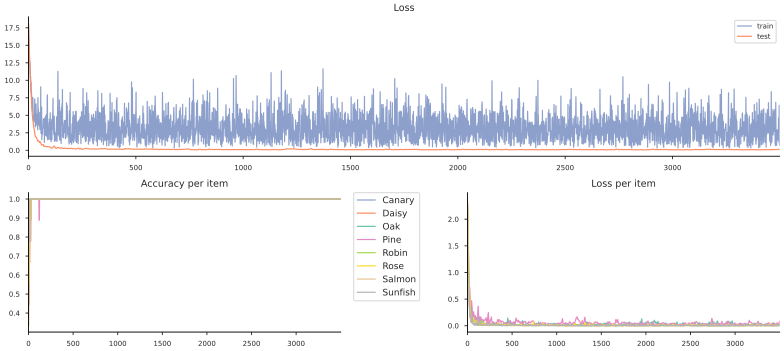

In [2]:
metrics1 = train_model(
    model1 := AutoEncoder(sizes=[dataloader.dataset.NUM_ATTRIBUTES, 32], batch_norm=False, dropout=0),
    optimizer1 := torch.optim.AdamW(model1.parameters(), lr=1e-2),
    loss_fn1 := torch.nn.MSELoss(reduction="sum"),
    dataloader,
    epochs=3500,
    noise_mean=0,
    noise_stdev=1,
    noise_multiplier=0.5,
    l1_lambda=0.0005,
)

plot_metrics(metrics1);

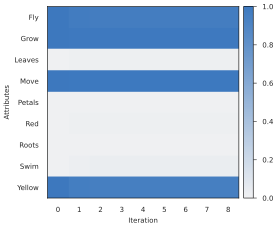

In [56]:
st, _ = iterate(
    model1,
    initial_state=torch.tensor(dataloader.dataset.df.loc["Canary", :], dtype=torch.float32),
    runs=1,
    steps=8,
)
ax = plot_tensor(st.transpose(1, 2))
ax.set_yticks(np.arange(0, 9))
ax.set_yticklabels(dataloader.dataset.df.columns)
ax.set_xlabel("Iteration")
ax.set_ylabel("Attributes")
plt.savefig('../plots/fixed_point_fromcanary_noadded')


In [3]:
from collections import defaultdict
from _work.src.modules.replay import iterate
from _work.src.modules.utils import get_closest_item


def transition_matrix(model, dataloader, mean=0, stdev=1, multiplier=1, runs=100, steps=10):
    transitions = defaultdict(lambda: defaultdict(lambda: 0))
    for item_a in dataloader.dataset.df.index:
        for item_b in dataloader.dataset.df.index:
            transitions[item_a][item_b] = 0

    for i, batch in enumerate(dataloader.dataset):
        origin = dataloader.dataset.df.index[i]
        item = batch["y"]

        states, _ = iterate(
            model,
            initial_state=item,
            mean=mean,
            stdev=stdev,
            multiplier=multiplier,
            runs=runs,
            steps=steps,
        )

        for final_state in states[:, 1:, :].reshape(-1, states.shape[-1]):
            closest_item, _ = get_closest_item(dataloader.dataset.df, final_state)
            transitions[origin][closest_item] += 1

    transitions = {k: dict(v) for k, v in transitions.items()}
    matrix = (
        pd.DataFrame(transitions)
        .transpose()
        .reindex(index=dataloader.dataset.df.index, columns=dataloader.dataset.df.index)
        .fillna(0)
        .astype(int)
    )
    matrix = matrix.divide(matrix.sum(axis=1), axis=0)
    return matrix

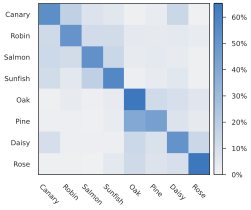

In [57]:
data = np.zeros((len(dataloader.dataset.df), len(dataloader.dataset.df)))
for i in range(data.shape[0]):
    for j in range(data.shape[1]):
        if i == j:
            data[i][j] += np.random.randint(150, 225)
        elif (
            (i >= 0 and j >= 0 and i <= 1 and j <= 1)
            or (i >= 2 and j >= 2 and i <= 3 and j <= 3)
            or (i >= 4 and j >= 4 and i <= 5 and j <= 5)
            or (i >= 6 and j >= 6 and i <= 7 and j <= 7)
        ):
            data[i][j] += np.random.randint(30, 60)
        elif (i >= 0 and j >= 0 and i <= 3 and j <= 3) or (i >= 4 and j >= 4 and i <= 7 and j <= 7):
            data[i][j] += np.random.randint(15, 50)
        else:
            # yes = np.random.choice([True, False], p=[0.8, 0.2])
            # if yes == True:
            #     data[i][j] += np.random.randint(0, 30)
            data[i][j] += np.random.randint(0, 20)
        if i == 5 and j == 4:
            data[i][j] += 150
        if i == 0 and j == 6:
            data[i][j] += 40
        if i == 6 and j == 0:
            data[i][j] += 20

index = ['Canary', 'Robin', 'Salmon', 'Sunfish', 'Oak', 'Pine', 'Daisy', 'Rose']
df = pd.DataFrame(data, index=index, columns=index)
df = df.divide(df.sum(axis=1), axis=0)
plot_tensor(df);
cbar = plt.gcf().axes[-2].findobj(lambda obj: hasattr(obj, 'colorbar') and obj.colorbar)[0]
cbar.colorbar.set_ticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6])
cbar.colorbar.set_ticklabels(['0%', '10%', '20%', '30%', '40%', '50%', '60%'])
# plt.savefig('../plots/transition_matrix_FINAL')

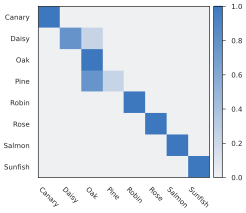

In [25]:
plot_tensor(transition_matrix(model1, dataloader, mean=0, stdev=0.5, multiplier=0.1, runs=1000, steps=20));

In [3]:
from torch.utils.data import Dataset, DataLoader
from _work.src.modules.replay import iterate

def generate_patterns(model, n_runs=1, n_steps=10, take_last=1, mean=0, stdev=1, multiplier=1):
    assert take_last <= n_steps

    states, _ = iterate(model, runs=n_runs, steps=n_steps, mean=mean, stdev=stdev, multiplier=multiplier)
    states = torch.vstack(tuple(states[:, -take_last:, :]))

    return states # n_runs * take_last

def create_dataloaders(states, n_epochs):
    class ReplayDataset(Dataset):
        def __init__(self, data):
            super().__init__()
            self.data = data
        
        def __len__(self):
            return len(self.data)
        
        def __getitem__(self, i):
            return {
                'y': self.data[i],
            }

    dataloaders = []
    for _ in range(n_epochs):
        indices = np.random.choice(list(range(len(states))), size=8, replace=False)
        data = ReplayDataset(states[indices])
        dl = DataLoader(data, shuffle=True, batch_size=4)
        dataloaders.append(dl)
    
    return dataloaders

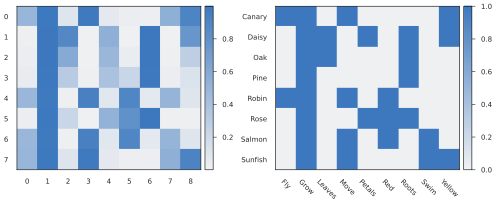

In [10]:
fig, axes = plt.subplots(ncols=2, figsize=(7, 7))

plot_tensor(torch.vstack([model1(x['y']) for x in dataloader.dataset]), ax=axes[0]);
plot_tensor(dataloader.dataset.df, ax=axes[1]);

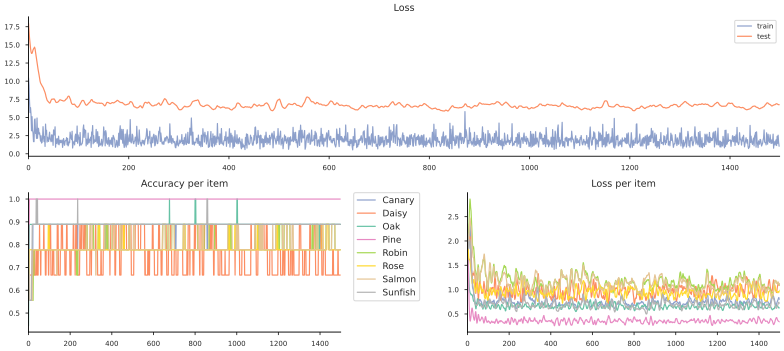

In [14]:
n_epochs = 1500

kwargs = {
    'mean': 0,
    'stdev': 0.5,
}

dataloaders = create_dataloaders(
    patterns := generate_patterns(
        model1,
        n_runs=5000,
        n_steps=20,
        take_last=5,
        **kwargs,
    ),
    n_epochs=n_epochs,
)

metrics2 = train_model(
    model2 := AutoEncoder(sizes=[dataloader.dataset.NUM_ATTRIBUTES, 32], batch_norm=False, dropout=0),
    optimizer2 := torch.optim.AdamW(model2.parameters(), lr=1e-2),
    loss_fn2 := torch.nn.MSELoss(reduction="sum"),
    dataloaders,
    test_loader=dataloader,
    epochs=n_epochs,
    noise_mean=0,
    noise_stdev=1,
    noise_multiplier=0.5,
    l1_lambda=0.0005,
)

plot_metrics(metrics2);

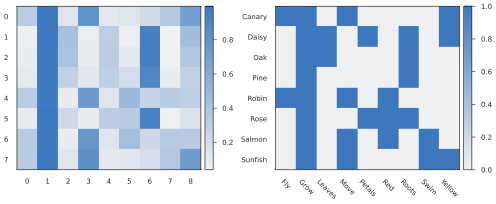

In [15]:
fig, axes = plt.subplots(ncols=2, figsize=(7, 7))

plot_tensor(torch.vstack([model2(x['y']) for x in dataloader.dataset]), ax=axes[0]);
plot_tensor(dataloader.dataset.df, ax=axes[1]);